 # Predicting Average Salary for MLB Free Agents
 
 Using previous year stats and career stats

In [1]:
# Load Modules 
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
scaler = StandardScaler()
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from tqdm import tqdm
import itertools 
pd.options.display.max_columns = None # Show all columns in Jupyter notebook
pd.set_option('display.max_rows', 2000) # Show all rows in Jupyter notebook

In [2]:
# Read In Data
Batter = pd.read_csv("batter_final_df.csv")
Pitcher = pd.read_csv("pitcher_final_df.csv")
Batter.head()
Pitcher.head()

,index,Name,Position,Age,From,To,Years,Dollars,Average_Salary,FA_year,bbrefID,Age_M1,Year,Age_prev,Tm,Lg,W,L,W-L%,ERA,G,GS,GF,CG,SHO,SV,IP,H,R,ER,HR,BB,IBB,SO,HBP,BK,WP,BF,ERA+,FIP,WHIP,H9,HR9,BB9,SO9,SO/W,WAR,W_accum,L_accum,W-L%_accum,ERA_accum,G_accum,GS_accum,GF_accum,CG_accum,SHO_accum,SV_accum,IP_accum,H_accum,R_accum,ER_accum,HR_accum,BB_accum,IBB_accum,SO_accum,HBP_accum,BK_accum,WP_accum,BF_accum,WHIP_accum,H9_accum,HR9_accum,BB9_accum,SO9_accum,SO/W_accum,WAR_accum
0,4,C.J. Wilson,SP,31,TEX,LAA,5,77500000,15500000,2012,wilsocj01,30,2011,30,TEX,AL,16,7,0.696,2.94,34,34,0,3,1,0,223.1,191,89,73,16,74,0,206,10,0,6,915,150.0,3.24,1.187,7.7,0.6,3.0,8.3,2.78,4.9,43.0,35.0,0.551,3.60,325.0,73.0,110.0,6.0,1.0,52.0,706.6,619.0,323.0,283.0,53.0,295.0,8.0,637.0,41.0,2.0,28.0,2998.0,1.294,7.9,0.7,3.8,8.1,2.16,11.6
1,5,Mark Buehrle,SP,33,CHW,MIA,4,58000000,14500000,2012,buehrma01,32,2011,32,CHW,AL,13,9,0.591,3.59,31,31,0,0,0,0,205.1,221,93,82,21,45,3,109,2,0,1,858,121.0,3.98,1.295,9.7,0.9,2.0,4.8,2.42,3.8,161.0,119.0,0.575,3.83,390.0,365.0,6.0,27.0,8.0,0.0,2474.1,2610.0,1171.0,1053.0,274.0,564.0,39.0,1396.0,55.0,15.0,21.0,10317.0,1.283,9.5,1.0,2.1,5.1,2.48,48.8
2,6,Jonathan Papelbon,RP,31,BOS,PHI,4,50000000,12500000,2012,papeljo01,30,2011,30,BOS,AL,4,1,0.800,2.94,63,0,54,0,0,31,64.1,50,22,21,3,10,1,87,3,0,1,255,147.0,1.53,0.933,7.0,0.4,1.4,12.2,8.70,1.6,23.0,19.0,0.548,2.33,396.0,3.0,334.0,0.0,0.0,219.0,428.4,322.0,126.0,111.0,31.0,115.0,10.0,509.0,17.0,0.0,10.0,1729.0,1.020,6.8,0.7,2.4,10.7,4.43,16.2
3,9,Heath Bell,RP,34,SD,MIA,3,27000000,9000000,2012,bellhe01,33,2011,33,SDP,NL,3,4,0.429,2.44,64,0,54,0,0,43,62.2,51,20,17,4,21,2,51,0,0,8,256,147.0,3.23,1.149,7.3,0.6,3.0,7.3,2.43,1.0,28.0,24.0,0.538,3.08,435.0,0.0,214.0,0.0,0.0,134.0,479.9,416.0,174.0,164.0,30.0,161.0,16.0,494.0,7.0,1.0,20.0,1974.0,1.202,7.8,0.6,3.0,9.3,3.07,8.4
4,14,Aaron Harang,SP,34,SD,LAD,2,12000000,6000000,2012,haranaa01,33,2011,33,SDP,NL,14,7,0.667,3.64,28,28,0,0,0,0,170.2,175,73,69,20,58,4,124,3,0,3,719,98.0,4.17,1.365,9.2,1.1,3.1,6.5,2.14,-0.9,95.0,94.0,0.503,4.26,268.0,262.0,2.0,13.0,6.0,0.0,1619.3,1721.0,813.0,767.0,217.0,465.0,36.0,1329.0,46.0,3.0,55.0,6939.0,1.350,9.6,1.2,2.6,7.4,2.86,18.8


In [3]:
# Features to keep in our model
all_features_b = ['Age', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB',
       'CS', 'BB', 'SO', 'BA', 'OBP', 'SLG', 'OPS', 'OPS+', 'TB', 'GDP', 'HBP',
       'SH', 'SF', 'IBB', 'WAR', 'G_accum', 'PA_accum', 'AB_accum', 'R_accum',
       'H_accum', '2B_accum', '3B_accum', 'HR_accum', 'RBI_accum', 'SB_accum',
       'CS_accum', 'BB_accum', 'IBB_accum', 'SO_accum', 'BA_accum', 'OBP_accum',
       'SLG_accum', 'OPS_accum', 'TB_accum', 'GDP_accum', 'HBP_accum',
       'SH_accum', 'SF_accum', '1B_accum', 'WAR_accum']

# Remove 'W-L%', 'W-L%_accum', 'BK_accum', 'BK' for pitchers 
all_features_p = ['W', 'L', 'ERA', 'G', 'GS', 'GF', 'CG', 'SHO', 'SV',
       'IP', 'H', 'R', 'ER', 'HR', 'BB', 'IBB', 'SO', 'HBP', 'WP', 'BF',
       'ERA+', 'FIP', 'WHIP', 'H9', 'HR9', 'BB9', 'SO9', 'SO/W', 'WAR',
       'W_accum', 'L_accum', 'ERA_accum', 'G_accum', 'GS_accum',
       'GF_accum', 'CG_accum', 'SHO_accum', 'SV_accum', 'IP_accum', 'H_accum',
       'R_accum', 'ER_accum', 'HR_accum', 'BB_accum', 'IBB_accum', 'SO_accum',
       'HBP_accum', 'WP_accum', 'BF_accum', 'WHIP_accum',
       'H9_accum', 'HR9_accum', 'BB9_accum', 'SO9_accum', 'SO/W_accum',
       'WAR_accum']

There are a lot of stats (variables) that we have to consider. Use model selection methods to help identify the most relevant variables. We start from stepwise regression and then move on to lasso regression.

## How do we do model selection?
According to the book 【An introduction to statistical learning】, there are 3 ways to find the "best" model. (p.204)
We will try to implement the first two methods. 

- 1. Subset Selection
    - Best Subset Selection
    - Stepwise Selection
- 2. Shrinkage Method
    - Ridge Regression
    - Lasso Regression
- 3. Dimension Reduction Methods
    - Principal Components Regression

### Some questions that I ask myself <br>

1. What is the optimal model?     <br>
The best model is the model that has the lowest test error. The metric for test error could be adjusted $R^2$, $AIC$, $BIC$ or $C_p$. Using different criteria would end up getting different optimal models. <br>

 <br>

2. How do I find the best model?    <br>
Ideally, we use best subset selection. Best subset selection builds models using all possible combination of features. If we have 10 features, we have to build $2^{10} = 1024$ different models. Then, we calculate all of their test errors, and find the best model with the least test error. Alternatively, we could use stepwise regression to reduce the required computing power. A forward stepwise regression starts with using only on variable. Then we compare the $n$ models (say we have $n$ independent variables) and keep the best model based on the given criterion. Next, we add one variable from the remaining $n-1$ variables to the model and compare again to find the best model. We repeat this process until we build a full model. If we have 10 features, we only need to build $\sum_{i=1}^{10} i = 55$ models in total. We pick from the 10 models that we keep and select the model with the lowest error. Backward stepwise regression starts by the full model and then removes one variable at a time.     <br> 

    <br> 
3. How do I know the test error is representative?  <br>
The test error is dependent on the train-test split, We can use k-fold cross validation to get a better test error. <br>

# Best Subset Selection (Criterion: Adjusted R-Sqaured)

Best Subset Selection trys to find the best model by comparing every possible model using all different combinations of features. We first build all possible one-variable models, keep track of the "best" model. Then, we build all possible two-variable models, record the best model and move on to build all possible three-variable models... until we build all possible models. The total amount of models we have to build for $k$ features are $2^k$ different models. You can think of it as for each feature, whether to put it in the model, yes or no.  If we have $10$ features, we have to build $2^{10} = 1,024$ features.  <br>

It is extremely computationally extensive to build so many models, and the number of models we need for each additional feature added are exponetially growing. To compare all possible models with all our $51$ variables, we would have to build over $2$ Quadrillion models ($ 2^{51} = 2,251,799,813,685,248$)!! In the following example, I use only 16 variables instead which we just have to build $65,536$ models in total. This is still a lot but comparing to 2 quadrillion, it's not that many. 

In [4]:
# Train test split 
X = Batter[all_features_b]
y = Batter["Average_Salary"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 1)

100%|██████████| 16/16 [01:37<00:00,  6.11s/it]


The best model is the model that has an adjusted R-Sqaured of 0.7002 which uses 12 variables.
The variables selected are ('Age', 'PA', 'H', 'HR', 'BB', 'OPS', 'WAR', 'PA_accum', 'H_accum', 'BB_accum', 'OPS_accum', 'WAR_accum')


Text(0.5, 1.0, 'Best Subset Selection (with 16 features)')

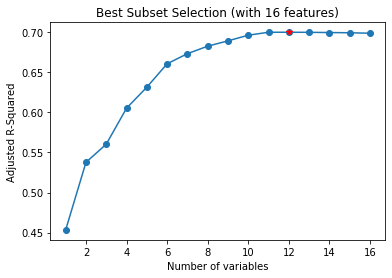

In [5]:
# Takes a while to run with 16 variables (65536 models)
df = Batter[["Age", "PA", "H", "HR", "RBI", "BB", "OPS", "OPS+", "WAR", "PA_accum", "H_accum", "HR_accum", "RBI_accum", "BB_accum", "OPS_accum", "WAR_accum"]]
y = Batter["Average_Salary"]
ncol = df.shape[1]
best_features_each_n = []
MaxadjR2_each_n = []
adjR2_each_n = []
for j in tqdm(range(len(df.columns))):     # Loop through each n (the number of variables used: 1 ~ ncol)
    adjR2_each_combin = []
    feature_combin = []
    for i in itertools.combinations(df.columns, j+1):   # Loop through all combinations of j (1~ncol)
        feature_combin.append(i)
        X = df.loc[:,i]
        X = X.assign(Intercept=1)
        ols = sm.OLS(y,X)
        results = ols.fit()
        adjR2 = results.rsquared_adj
        adjR2_each_combin.append(adjR2)  # A list of adjR2 in this inner loop 
    MaxadjR2 = max(adjR2_each_combin)
    MaxadjR2_each_n.append(MaxadjR2)     # A list of highest adjR2 in each round 
    MaxadjR2_index = adjR2_each_combin.index(MaxadjR2)
    best_features = feature_combin[MaxadjR2_index]       # The features selected under each n 
    best_features_each_n.append(best_features)           # A list of selected features in each n
    adjR2_each_n.append(adjR2_each_combin)               # Record ALL adjR2 for every model built
print("The best model is the model that has an adjusted R-Sqaured of {:.4f} which uses {} variables.".format(max(MaxadjR2_each_n), MaxadjR2_each_n.index(max(MaxadjR2_each_n)) + 1))
print("The variables selected are", best_features_each_n[MaxadjR2_each_n.index(max(MaxadjR2_each_n))])
plt.plot(np.linspace(1, ncol, ncol), MaxadjR2_each_n, marker = "o")
plt.plot(MaxadjR2_each_n.index(max(MaxadjR2_each_n)) + 1, max(MaxadjR2_each_n), marker = "*", color = "red")
plt.xlabel("Number of variables")
plt.ylabel("Adjusted R-Squared")
plt.title("Best Subset Selection (with 16 features)")

In [6]:
best_features_each_n[0:5]

[('RBI',),
 ('RBI', 'WAR'),
 ('PA', 'H', 'BB'),
 ('PA', 'H', 'HR', 'BB'),
 ('PA', 'H', 'HR', 'BB', 'WAR')]

The one-variable model selected "RBI".  <br>
The two-variable model selected "RBI" and "WAR".  <br>
The three-variable model selected "PA", "H", and "BB".  <br>
We can see that the variables in the one-variable model ("R") was not selected in the three-variable model. Unlike stepwise regression, where you add/subtract one variable into/from the list of variables, the best selection model seeks to find the best model within all combinations at a given number of variables.  

# Stepwise Regression

In stepwise regression, we start with finding the best one-variable model, just like the best subset selection. Then, we find the best variable to add into the model. We do not have to run all the two-variable models, we only have to run $2-k$ models. 
Once the variable is selected, it will stay in the model. So in the previous example, the three-variable model does not include the variables selected in the two-variable model. This will NOT happen in stepwise regression, as we try to find the best variable to add into the existing model. <br>

There are two types of stepwise regression: forward and backward.
The forward stepwise regression starts with finding the first feature and try adding variables into the model. On the other hand, the backward stepwise regression starts with the full model, then it tries to remove one feature at a time. With three different criteria, we will have $3*2=6$ different stepwise models.

## Forward Stepwise Regression (Adjusted R-Squared)

The largest Adjusted R-Squared is found using 27 features, with Adjusted R-Squared of 72.98%
The selected features are: ['R', 'WAR', 'G', 'IBB', 'TB', 'AB', 'BB', 'BA_accum', 'Age', 'SLG', 'WAR_accum', 'R_accum', 'SO', 'SB', 'SLG_accum', 'SH_accum', 'GDP', 'H', '2B_accum', 'OBP_accum', 'OPS+', 'OPS', '3B', 'SO_accum', 'OBP', 'SF', 'RBI']


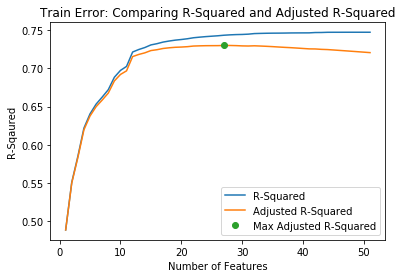

In [7]:
df = Batter.iloc[:,np.append(2, np.arange(15,65))]
df_temp = Batter.iloc[:,np.append(2, np.arange(15,65))]
selected_features_train = []
r_squared_train = []
adjr_squared_train = []
n = df.shape[0]          # Number of rows: To calculate adjusted R squared
ncol = df.shape[1]
for k in range(ncol):    # k = number of features used
    r_squared_list = []
    adjr_squared_list = []
    if k == 0:              # To find the first feature that has the highest adjusted R-squared
        for i in df.columns: 
            X = df.loc[:,i].to_frame()
            y = Batter["Average_Salary"]
            model = LinearRegression()
            model.fit(X,y)
            ypred = model.predict(X)
            rsquared = r2_score(y, ypred)
            adjR = rsquared - (((k+1-1)/(n-(k+1)))*(1-rsquared))
            r_squared_list.append(rsquared)
            adjr_squared_list.append(adjR)
        MaxR = max(r_squared_list)            # The Max R squared in this step
        MaxAdjR = max(adjr_squared_list)      # The Max adj. R squared in this step
        best_adjr_index = adjr_squared_list.index(max(adjr_squared_list))        # The column index of the best feature in this step
        selected_features_train.append(df.columns[best_adjr_index])              # Record the selected feature
        df_temp = df.drop(columns = selected_features_train)                     # Drop the temporary df columns
        feature_this_step = df.columns[best_adjr_index]                     
    else:                 # More than 2 variables 
        r_squared_list = []
        adjr_squared_list = []
        for j in df_temp.columns:
            X = df.loc[:, np.append(selected_features_train, j)]
            y = Batter["Average_Salary"]
            model = LinearRegression()
            model.fit(X,y)
            ypred = model.predict(X)
            rsquared = r2_score(y, ypred)
            adjR = rsquared - (((k+1-1)/(n-(k+1)))*(1-rsquared))
            r_squared_list.append(rsquared)
            adjr_squared_list.append(adjR)
        MaxR = max(r_squared_list)             # The Max R squared in this step
        MaxAdjR = max(adjr_squared_list)       # The Max adj. R squared in this step
        best_adjr_index = adjr_squared_list.index(max(adjr_squared_list))     # The column index of the best feature in this step
        feature_this_step = df_temp.columns[best_adjr_index]                  # Record the selected feature
        selected_features_train.append(feature_this_step)                           # Record the selected feature
        df_temp = df.drop(columns = selected_features_train)                        # Drop the temporary df columns
    r_squared_train.append(MaxR)                    # Record the best R squared in each step
    adjr_squared_train.append(MaxAdjR)              # Record the best adjusted R squared in each step
selected_features_fwd_adjR2 = selected_features_train[0:27]    
    
plt.plot(np.arange(1, ncol+1), r_squared_train, label = "R-Squared")
plt.plot(np.arange(1, ncol+1), adjr_squared_train, label = "Adjusted R-Squared")
# plt.plot(r_squared_train.index(max(r_squared_train))+ 1, max(r_squared_train), "o", label = "Max R-Squared")
plt.plot(adjr_squared_train.index(max(adjr_squared_train))+ 1, max(adjr_squared_train), "o", label = "Max Adjusted R-Squared")
plt.title("Train Error: Comparing R-Squared and Adjusted R-Squared")
plt.xlabel("Number of Features")
plt.ylabel("R-Sqaured")
plt.legend()

print("The largest Adjusted R-Squared is found using {} features, with Adjusted R-Squared of {:.2%}".format(adjr_squared_train.index(max(adjr_squared_train))+ 1, max(adjr_squared_train)))
print("The selected features are:", selected_features_fwd_adjR2)

The one-variable model first picked "R". Then the two-variable model added "WAR". After that, the three-variable model added "G". And the list goes on... The variables picked at the beginning will always remain in the process as the algorithm tries to add the best feature into the existed model.   <br> 

The blue line represents the highest $R^2$ at different step while the orange line shows the $adjusted R^2$. $R^2$ will always increase when we add more variables into the model because adding a new variable will always make the regression line fit better in the training set. $Adjusted R^2$ adds a pentaly to the number of features used to account for the bias due to overfitting the training error.  <br>

## Build model based on forward selection (Adjusted R-Squared)

In [8]:
# Best model based on Forward Stepwise Regression
X = df[selected_features_fwd_adjR2]
X = scaler.fit_transform(X)
X = pd.DataFrame(X)
X.columns = selected_features_fwd_adjR2
X = X.assign(Intercept=1)
ols = sm.OLS(y,X)
results = ols.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         Average_Salary   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     53.38
Date:                Wed, 02 Sep 2020   Prob (F-statistic):          1.80e-128
Time:                        15:07:07   Log-Likelihood:                -8565.1
No. Observations:                 526   AIC:                         1.719e+04
Df Residuals:                     498   BIC:                         1.731e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
R           1.994e+06   5.97e+05      3.343      0.0

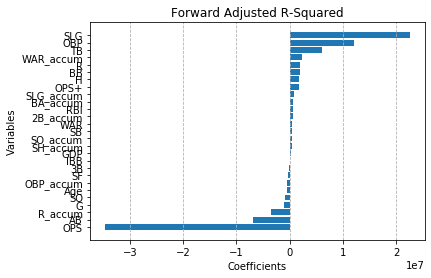

In [9]:
df_adjR_F = pd.DataFrame(results.params)
df_adjR_F.index.name = 'Variable'
df_adjR_F.reset_index(inplace=True)
df_adjR_F.columns = ["Variable", "Coefficient"]
df_adjR_F = df_adjR_F.sort_values(by = "Coefficient")
df_adjR_F = df_adjR_F[df_adjR_F["Variable"] != "Intercept"]

fig, ax = plt.subplots()
y_pos = np.arange(df_adjR_F.shape[0])
ax.barh(y_pos, df_adjR_F["Coefficient"], align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(df_adjR_F["Variable"])
ax.set_title("Forward Adjusted R-Squared")
ax.set_xlabel("Coefficients")
ax.set_ylabel("Variables")
ax.xaxis.grid(linestyle='--')

The variables selected are: 'R', 'WAR', 'G', 'IBB', 'TB', 'AB', 'BB', 'BA_accum', 'Age', 'SLG', 'WAR_accum', 'R_accum', 'SO', 'SB', 'SLG_accum', 'SH_accum', 'GDP', 'H', '2B_accum', 'OBP_accum', 'OPS+', 'OPS', '3B', 'SO_accum', 'OBP', 'SF', 'RBI'. However, only some are significant (p-value < 0.05): 'R', 'WAR', 'G', 'TB', 'AB', 'BB', 'BA_accum', 'Age', 'WAR_accum', 'R_accum', 'SO', 'SB', 'SLG_accum', 'SH_accum', 'OPS+'.  <br>

Most of the coefficients of significant variables make sense to me. 'R', 'WAR', 'TB', 'BB', 'BA_accum', 'WAR_accum', 'SB', 'SLG_accum', 'SH_accum', 'OPS+' are all positive. The higher the WAR, the higher the OPS+, the better a hitter is. On the other hand, the coefficients for 'G', 'AB', 'Age', 'R_accum', 'SO' are negative. Age and SO are not surprising, because the older a player is, the more strike outs a player gets, the less valuable a player is to a team. However, G, AB and R_accum are also negative, these are surprising to me and I don't have good explanation for them. 

## Forward Stepwise Regression (AIC)

The largest Adjusted R-Squared is found using 22 features, with AIC of 1.7e+04
The selected features are: ['R', 'WAR', 'G', 'IBB', 'TB', 'AB', 'BB', 'BA_accum', 'Age', 'SLG', 'WAR_accum', 'R_accum', 'SO', 'SB', 'SLG_accum', 'SH_accum', 'GDP', 'H', '2B_accum', 'OBP_accum', 'OPS+', 'OPS']


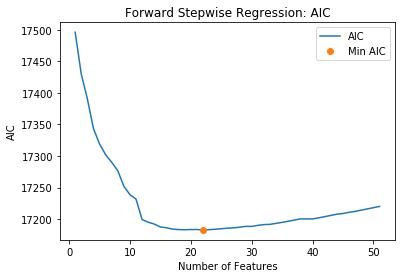

In [10]:
df = Batter.iloc[:,np.append(2, np.arange(15,65))]
df_temp = Batter.iloc[:,np.append(2, np.arange(15,65))]
selected_features_train = []
AIC_train = []
n = df.shape[0]          # Number of rows: To calculate adjusted R squared
ncol = df.shape[1]
for k in range(ncol):    # k = number of features used
    AIC_list = []
    adjr_squared_list = []
    if k == 0:              # To find the first feature that has the highest adjusted R-squared
        for i in df.columns: 
            X = df.loc[:,i].to_frame()
            X = X.assign(Intercept=1)
            y = Batter["Average_Salary"]
            ols = sm.OLS(y,X)
            results = ols.fit()
            AIC = results.aic
            AIC_list.append(AIC)
            adjr_squared_list.append(adjR)
        MinAIC = min(AIC_list)            # The Max R squared in this step
        best_AIC_index = AIC_list.index(MinAIC)        # The column index of the best feature in this step
        selected_features_train.append(df.columns[best_AIC_index])              # Record the selected feature
        df_temp = df.drop(columns = selected_features_train)                     # Drop the temporary df columns
        feature_this_step = df.columns[best_AIC_index]                     
    else:                 # Not the last
        r_squared_list = []
        adjr_squared_list = []
        for j in df_temp.columns:
            X = df.loc[:, np.append(selected_features_train, j)]
            X = X.assign(Intercept=1)
            y = Batter["Average_Salary"]
            ols = sm.OLS(y,X)
            results = ols.fit()
            AIC = results.aic
            AIC_list.append(AIC)
            adjr_squared_list.append(adjR)
        MinAIC = min(AIC_list)             # The Max R squared in this step
        best_AIC_index = AIC_list.index(MinAIC)     # The column index of the best feature in this step
        feature_this_step = df_temp.columns[best_AIC_index]                  # Record the selected feature
        selected_features_train.append(feature_this_step)                           # Record the selected feature
        df_temp = df.drop(columns = selected_features_train)                        # Drop the temporary df columns
    AIC_train.append(MinAIC)                    # Record the best R squared in each step

bestAIC_index = AIC_train.index(min(AIC_train))    
selected_features_fwd_AIC = selected_features_train[0:bestAIC_index+1]    
    
plt.plot(np.arange(1, ncol+1), AIC_train, label = "AIC")
plt.plot(AIC_train.index(min(AIC_train))+ 1, min(AIC_train), "o", label = "Min AIC")
plt.title("Forward Stepwise Regression: AIC")
plt.xlabel("Number of Features")
plt.ylabel("AIC")
plt.legend()

print("The largest Adjusted R-Squared is found using {} features, with AIC of {:.2}".format(AIC_train.index(min(AIC_train))+ 1, min(AIC_train)))
print("The selected features are:", selected_features_fwd_AIC)

'R', 'WAR', 'G', 'IBB', 'TB', 'AB', 'BB', 'BA_accum', 'Age', 'SLG', 'WAR_accum', 'R_accum', 'SO', 'SB', 'SLG_accum', 'SH_accum', 'GDP', 'H', '2B_accum', 'OBP_accum', 'OPS+', 'OPS', '3B', 'SO_accum', 'OBP', 'SF', 'RBI'

## Build model based on forward selection (AIC)

In [11]:
# Best model based on Forward Stepwise Regression
X = df[selected_features_fwd_AIC]
X = scaler.fit_transform(X)
X = pd.DataFrame(X)
X.columns = selected_features_fwd_AIC
X = X.assign(Intercept=1)
ols = sm.OLS(y,X)
results = ols.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         Average_Salary   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     65.04
Date:                Wed, 02 Sep 2020   Prob (F-statistic):          1.41e-131
Time:                        15:07:09   Log-Likelihood:                -8568.4
No. Observations:                 526   AIC:                         1.718e+04
Df Residuals:                     503   BIC:                         1.728e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
R           1.783e+06   5.86e+05      3.040      0.0

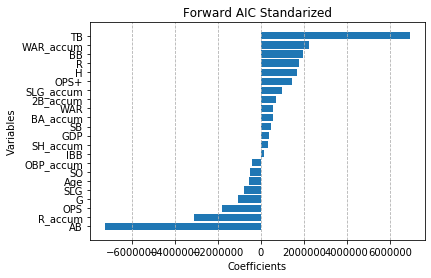

In [12]:
df_AIC_F = pd.DataFrame(results.params)
df_AIC_F.index.name = 'Variable'
df_AIC_F.reset_index(inplace=True)
df_AIC_F.columns = ["Variable", "Coefficient"]
df_AIC_F = df_AIC_F.sort_values(by = "Coefficient")
df_AIC_F = df_AIC_F[df_AIC_F["Variable"] != "Intercept"]

fig, ax = plt.subplots()
y_pos = np.arange(df_AIC_F.shape[0])
ax.barh(y_pos, df_AIC_F["Coefficient"], align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(df_AIC_F["Variable"])
ax.set_title("Forward AIC Standarized")
ax.set_xlabel("Coefficients")
ax.set_ylabel("Variables")
ax.xaxis.grid(linestyle='--')

Like the adjusted R-Squared model, most of the features make sense. However, OPS and SLG both have negative coefficients which does not seem right to me.

## Forward Stepwise Regression (BIC)

The minimum BIC is found using 12 features, with BIC of 1.7e+04
The selected features are: ['R', 'WAR', 'G', 'IBB', 'TB', 'AB', 'BB', 'BA_accum', 'Age', 'SLG', 'WAR_accum', 'R_accum']


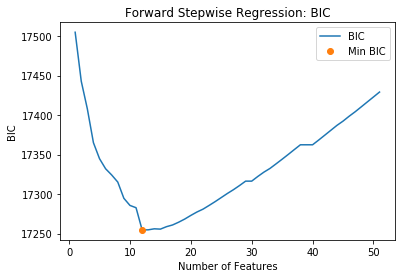

In [13]:
df = Batter.iloc[:,np.append(2, np.arange(15,65))]
df_temp = Batter.iloc[:,np.append(2, np.arange(15,65))]
selected_features_train = []
BIC_train = []
n = df.shape[0]          # Number of rows: To calculate adjusted R squared
ncol = df.shape[1]
for k in range(ncol):    # k = number of features used
    BIC_list = []
    adjr_squared_list = []
    if k == 0:              # To find the first feature that has the highest adjusted R-squared
        for i in df.columns: 
            X = df.loc[:,i].to_frame()
            X = X.assign(Intercept=1)
            y = Batter["Average_Salary"]
            ols = sm.OLS(y,X)
            results = ols.fit()
            BIC = results.bic
            BIC_list.append(BIC)
        MinBIC = min(BIC_list)            # The Max R squared in this step
        best_BIC_index = BIC_list.index(MinBIC)        # The column index of the best feature in this step
        selected_features_train.append(df.columns[best_BIC_index])              # Record the selected feature
        df_temp = df.drop(columns = selected_features_train)                     # Drop the temporary df columns
        feature_this_step = df.columns[best_BIC_index]                     
    else:                 # Not the last
        r_squared_list = []
        adjr_squared_list = []
        for j in df_temp.columns:
            X = df.loc[:, np.append(selected_features_train, j)]
            X = X.assign(Intercept=1)
            y = Batter["Average_Salary"]
            ols = sm.OLS(y,X)
            results = ols.fit()
            BIC = results.bic
            BIC_list.append(BIC)
        MinBIC = min(BIC_list)             # The Max R squared in this step
        best_BIC_index = BIC_list.index(MinBIC)     # The column index of the best feature in this step
        feature_this_step = df_temp.columns[best_BIC_index]                  # Record the selected feature
        selected_features_train.append(feature_this_step)                           # Record the selected feature
        df_temp = df.drop(columns = selected_features_train)                        # Drop the temporary df columns
    BIC_train.append(MinBIC)                    # Record the best R squared in each step

bestBIC_index = BIC_train.index(min(BIC_train))    
selected_features_fwd_BIC = selected_features_train[0:bestBIC_index+1]    
    
plt.plot(np.arange(1, ncol+1), BIC_train, label = "BIC")
plt.plot(BIC_train.index(min(BIC_train))+ 1, min(BIC_train), "o", label = "Min BIC")
plt.title("Forward Stepwise Regression: BIC")
plt.xlabel("Number of Features")
plt.ylabel("BIC")
plt.legend()

print("The minimum BIC is found using {} features, with BIC of {:.2}".format(BIC_train.index(min(BIC_train))+ 1, min(BIC_train)))
print("The selected features are:", selected_features_fwd_BIC)

## Build model based on forward selection (BIC)

In [14]:
# Best model based on Forward Stepwise Regression
X = df[selected_features_fwd_BIC]
X = scaler.fit_transform(X)
X = pd.DataFrame(X)
X.columns = selected_features_fwd_BIC
X = X.assign(Intercept=1)
ols = sm.OLS(y,X)
results = ols.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         Average_Salary   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     110.6
Date:                Wed, 02 Sep 2020   Prob (F-statistic):          9.57e-134
Time:                        15:07:12   Log-Likelihood:                -8586.6
No. Observations:                 526   AIC:                         1.720e+04
Df Residuals:                     513   BIC:                         1.725e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
R           1.725e+06    4.9e+05      3.520      0.0

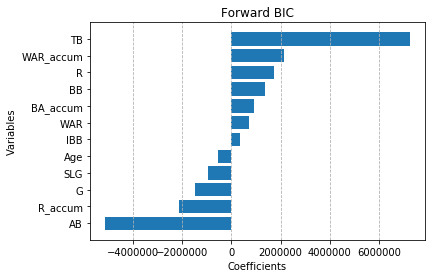

In [15]:
df_BIC_F = pd.DataFrame(results.params)
df_BIC_F.index.name = 'Variable'
df_BIC_F.reset_index(inplace=True)
df_BIC_F.columns = ["Variable", "Coefficient"]
df_BIC_F = df_BIC_F.sort_values(by = "Coefficient")
df_BIC_F = df_BIC_F[df_BIC_F["Variable"] != "Intercept"]

fig, ax = plt.subplots()
y_pos = np.arange(df_BIC_F.shape[0])
ax.barh(y_pos, df_BIC_F["Coefficient"], align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(df_BIC_F["Variable"])
ax.set_title("Forward BIC")
ax.set_xlabel("Coefficients")
ax.set_ylabel("Variables")
ax.xaxis.grid(linestyle='--')

The features that we selected are fewer in the BIC stepwise regression. Still, some of the coefficients just don't seem right, such as negative coefficients for SLG and AB. 

## Backward Stepwise Regression (Adjusted R-Squared)

The largest Adjusted R-Squared is found using 24 features, with Adjusted R-Squared of 72.97%
The selected features are: ['1B_accum' '2B' 'Age' 'BA_accum' 'BB' 'BB_accum' 'G' 'GDP' 'H' 'HR' 'OPS'
 'OPS+' 'PA' 'PA_accum' 'R' 'RBI' 'RBI_accum' 'R_accum' 'SB' 'SLG_accum'
 'SO' 'TB_accum' 'WAR' 'WAR_accum']


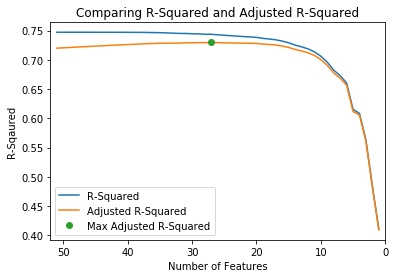

In [16]:
# Full Model
df = Batter.iloc[:,np.append(2, np.arange(15,65))]
X = df
y = Batter["Average_Salary"]
n = X.shape[0]     # Number of Observation
k = X.shape[1]     # Number of Features   
model = LinearRegression()
model.fit(X,y)
ypred = model.predict(X)
rsquared = r2_score(y, ypred)
adjR = rsquared - (((k+1-1)/(n-(k+1)))*(1-rsquared))

# Backward Stepwise Regression
df_temp = Batter.iloc[:,np.append(2, np.arange(15,65))]
features_dropped = []
r_squared = [rsquared]
adjr_squared = [adjR]
n = df.shape[0]          # To calculate adjusted R squared
ncol = df.shape[1]
for j in range(ncol-1):
    r_squared_list = []
    adjr_squared_list = []
    feature_dropped_step = []
    if j == 0:              # To find the first feature to drop
        for i in df.columns:
            X = df.drop(columns = i)
            y = Batter["Average_Salary"]
            n = X.shape[0]     # Number of Observation
            k = X.shape[1]     # Number of Features   
            model = LinearRegression()
            model.fit(X,y)
            ypred = model.predict(X)
            rsquared = r2_score(y, ypred)
            adjR = rsquared - (((k+1-1)/(n-(k+1)))*(1-rsquared))
            r_squared_list.append(rsquared)
            adjr_squared_list.append(adjR)
            feature_dropped_step.append(i)
        MaxR = max(r_squared_list)            # The Max R squared in this step
        MaxAdjR = max(adjr_squared_list)      # The Max adj. R squared in this step
        best_adjr_index = adjr_squared_list.index(max(adjr_squared_list))
        features_dropped.append(feature_dropped_step[best_adjr_index])
        r_squared.append(MaxR)
        adjr_squared.append(MaxAdjR)
        df_temp = df.drop(columns = features_dropped, axis = 1)    
    else:
        for i in df_temp.columns:
            X = df_temp.drop(columns = i)
            y = Batter["Average_Salary"]
            n = X.shape[0]     # Number of Observation
            k = X.shape[1]     # Number of Features   
            model = LinearRegression()
            model.fit(X,y)
            ypred = model.predict(X)
            rsquared = r2_score(y, ypred)
            adjR = rsquared - (((k+1-1)/(n-(k+1)))*(1-rsquared))
            r_squared_list.append(rsquared)
            adjr_squared_list.append(adjR)
            feature_dropped_step.append(i)
        MaxR = max(r_squared_list)            # The Max R squared in this step
        MaxAdjR = max(adjr_squared_list)      # The Max adj. R squared in this step
        best_adjr_index = adjr_squared_list.index(max(adjr_squared_list))
        features_dropped.append(feature_dropped_step[best_adjr_index])
        r_squared.append(MaxR)
        adjr_squared.append(MaxAdjR)
        df_temp = df.drop(columns = features_dropped, axis = 1)

selected_features_bwd_adjR2 = np.setdiff1d(df.columns,features_dropped[0:27])
print("The largest Adjusted R-Squared is found using {} features, with Adjusted R-Squared of {:.2%}".format(adjr_squared.index(max(adjr_squared)), max(adjr_squared)))
print("The selected features are:", selected_features_bwd_adjR2)
plt.plot(np.arange(ncol, 0, -1), r_squared, label = "R-Squared")
plt.plot(np.arange(ncol, 0, -1), adjr_squared, label = "Adjusted R-Squared")
plt.plot(51 - adjr_squared.index(max(adjr_squared)), max(adjr_squared), "o", label = "Max Adjusted R-Squared")
plt.xlim(52, 0)
plt.title("Comparing R-Squared and Adjusted R-Squared")
plt.xlabel("Number of Features")
plt.ylabel("R-Sqaured")
plt.legend()

## Model based on backward selection (Adjusted R-Squared)

In [17]:
# Best model based on Forward Stepwise Regression
X = df[selected_features_bwd_adjR2]
X = scaler.fit_transform(X)
X = pd.DataFrame(X)
X.columns = selected_features_bwd_adjR2
X = X.assign(Intercept=1)
ols = sm.OLS(y,X)
results = ols.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         Average_Salary   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     59.79
Date:                Wed, 02 Sep 2020   Prob (F-statistic):          2.63e-130
Time:                        15:07:15   Log-Likelihood:                -8567.1
No. Observations:                 526   AIC:                         1.718e+04
Df Residuals:                     501   BIC:                         1.729e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
1B_accum   -2.344e+06      1e+06     -2.345      0.0

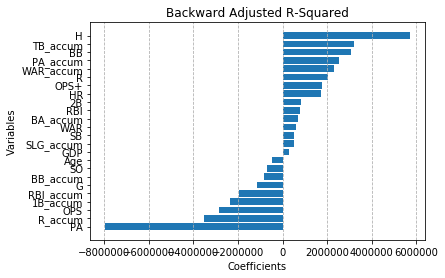

In [18]:
df_adjR_B = pd.DataFrame(results.params)
df_adjR_B.index.name = 'Variable'
df_adjR_B.reset_index(inplace=True)
df_adjR_B.columns = ["Variable", "Coefficient"]
df_adjR_B = df_adjR_B.sort_values(by = "Coefficient")
df_adjR_B = df_adjR_B[df_adjR_B["Variable"] != "Intercept"]

fig, ax = plt.subplots()
y_pos = np.arange(df_adjR_B.shape[0])
ax.barh(y_pos, df_adjR_B["Coefficient"], align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(df_adjR_B["Variable"])
ax.set_title("Backward Adjusted R-Squared")
ax.set_xlabel("Coefficients")
ax.set_ylabel("Variables")
ax.xaxis.grid(linestyle='--')

The results we get using backward regression is pretty similar to forward selection. 

## Backward Stepwise Regression (AIC)

The min AIC is found using 20 features, with AIC of 1.7e+04
The remaining features are: ['1B_accum' '3B' 'Age' 'BA_accum' 'BB' 'G' 'HR' 'OPS' 'OPS+' 'PA' 'R'
 'RBI' 'RBI_accum' 'R_accum' 'SB' 'SO' 'TB' 'TB_accum' 'WAR' 'WAR_accum']


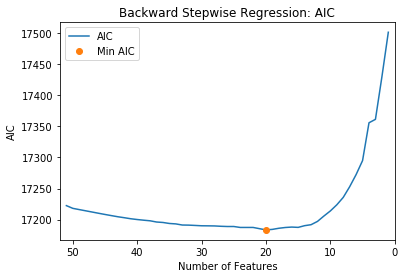

In [19]:
# Full Model
df = Batter.iloc[:,np.append(2, np.arange(15,65))]
X = df
y = Batter["Average_Salary"]
ols = sm.OLS(y,X)
results = ols.fit()
AIC_full = results.aic

# Backward Stepwise Regression
df_temp = Batter.iloc[:,np.append(2, np.arange(15,65))]
features_dropped = []
AIC = [AIC_full]           # The first AIC is the full model, the second will be the best 51-1 features model
ncol = df.shape[1]
for j in range(ncol-1):
    AIC_list = []
    feature_dropped_step = []
    if j == 0:              # To find the first feature to drop
        for i in df.columns:
            X = df.drop(columns = i)
            X = X.assign(Intercept=1)
            y = Batter["Average_Salary"]
            ols = sm.OLS(y,X)
            results = ols.fit()
            AIC_step = results.aic
            AIC_list.append(AIC_step)
            feature_dropped_step.append(i)
        MinAIC = min(AIC_list)            
        best_AIC_index = AIC_list.index(min(AIC_list))
        features_dropped.append(feature_dropped_step[best_AIC_index])
        AIC.append(MinAIC)
        df_temp = df.drop(columns = features_dropped, axis = 1)    
    else:
        for i in df_temp.columns:
            X = df_temp.drop(columns = i)
            X = X.assign(Intercept=1)
            y = Batter["Average_Salary"]
            ols = sm.OLS(y,X)
            results = ols.fit()
            AIC_step = results.aic
            AIC_list.append(AIC_step)
            feature_dropped_step.append(i)
        MinAIC = min(AIC_list)           
        best_AIC_index = AIC_list.index(min(AIC_list))
        features_dropped.append(feature_dropped_step[best_AIC_index])
        AIC.append(MinAIC)
        df_temp = df.drop(columns = features_dropped, axis = 1)

# Lowest AIC is AIC[30] meaning that the number of featrues used (remained) are 51-30 = 21       
MinAIC_n_features = 51 - AIC.index(min(AIC))
selected_features_bwd_AIC = np.setdiff1d(df.columns,features_dropped[0:AIC.index(min(AIC))]) # Return the unique values in ar1 that are not in ar2.
print("The min AIC is found using {} features, with AIC of {:.2}".format(MinAIC_n_features, min(AIC)))
print("The remaining features are:", selected_features_bwd_AIC)
plt.plot(np.arange(ncol, 0, -1), AIC, label = "AIC")
plt.plot(MinAIC_n_features, min(AIC), "o", label = "Min AIC")
plt.xlim(52, 0)
plt.title("Backward Stepwise Regression: AIC")
plt.xlabel("Number of Features")
plt.ylabel("AIC")
plt.legend()

## Model based on backward selection (AIC)

In [20]:
# Best model based on Backward Stepwise Regression
X = df[selected_features_bwd_AIC]
X = scaler.fit_transform(X)
X = pd.DataFrame(X)
X.columns = selected_features_bwd_AIC
X = X.assign(Intercept=1)
ols = sm.OLS(y,X)
results = ols.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         Average_Salary   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     70.99
Date:                Wed, 02 Sep 2020   Prob (F-statistic):          1.70e-132
Time:                        15:07:18   Log-Likelihood:                -8570.7
No. Observations:                 526   AIC:                         1.718e+04
Df Residuals:                     505   BIC:                         1.727e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
1B_accum   -1.826e+06    6.8e+05     -2.684      0.0

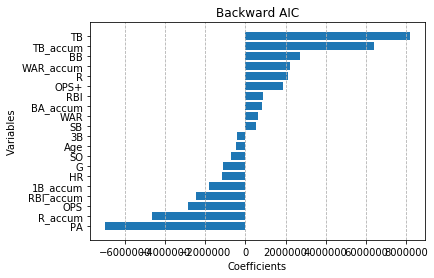

In [21]:
df_AIC_B = pd.DataFrame(results.params)
df_AIC_B.index.name = 'Variable'
df_AIC_B.reset_index(inplace=True)
df_AIC_B.columns = ["Variable", "Coefficient"]
df_AIC_B = df_AIC_B.sort_values(by = "Coefficient")
df_AIC_B = df_AIC_B[df_AIC_B["Variable"] != "Intercept"]

fig, ax = plt.subplots()
y_pos = np.arange(df_AIC_B.shape[0])
ax.barh(y_pos, df_AIC_B["Coefficient"], align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(df_AIC_B["Variable"])
ax.set_title("Backward AIC")
ax.set_xlabel("Coefficients")
ax.set_ylabel("Variables")
ax.xaxis.grid(linestyle='--')

## Backward Stepwise Regression (BIC)

The min BIC is found using 12 features, with BIC of 1.7e+04
The remaining features are: ['Age' 'BA_accum' 'BB' 'G' 'HR' 'OPS' 'PA' 'R' 'R_accum' 'TB' 'WAR'
 'WAR_accum']


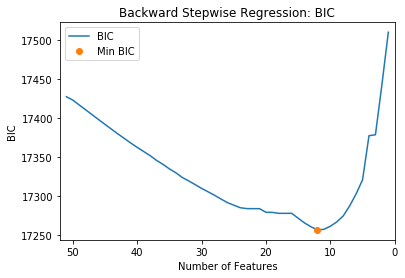

In [22]:
# Full Model
df = Batter.iloc[:,np.append(2, np.arange(15,65))]
X = df
y = Batter["Average_Salary"]
ols = sm.OLS(y,X)
results = ols.fit()
BIC_full = results.bic

# Backward Stepwise Regression
df_temp = Batter.iloc[:,np.append(2, np.arange(15,65))]
features_dropped = []
BIC = [BIC_full]           # The first AIC is the full model, the second will be the best 51-1 features model
ncol = df.shape[1]
for j in range(ncol-1):
    BIC_list = []
    feature_dropped_step = []
    if j == 0:              # To find the first feature to drop
        for i in df.columns:
            X = df.drop(columns = i)
            X = X.assign(Intercept=1)
            y = Batter["Average_Salary"]
            ols = sm.OLS(y,X)
            results = ols.fit()
            BIC_step = results.bic
            BIC_list.append(BIC_step)
            feature_dropped_step.append(i)
        MinBIC = min(BIC_list)            
        best_BIC_index = BIC_list.index(min(BIC_list))
        features_dropped.append(feature_dropped_step[best_BIC_index])
        BIC.append(MinBIC)
        df_temp = df.drop(columns = features_dropped, axis = 1)    
    else:
        for i in df_temp.columns:
            X = df_temp.drop(columns = i)
            X = X.assign(Intercept=1)
            y = Batter["Average_Salary"]
            ols = sm.OLS(y,X)
            results = ols.fit()
            BIC_step = results.bic
            BIC_list.append(BIC_step)
            feature_dropped_step.append(i)
        MinBIC = min(BIC_list)           
        best_BIC_index = BIC_list.index(min(BIC_list))
        features_dropped.append(feature_dropped_step[best_BIC_index])
        BIC.append(MinBIC)
        df_temp = df.drop(columns = features_dropped, axis = 1)

# Lowest AIC is AIC[30] meaning that the number of featrues used (remained) are 51-30 = 21       
MinBIC_n_features = 51 - BIC.index(min(BIC))
selected_features_bwd_BIC = np.setdiff1d(df.columns,features_dropped[0:BIC.index(min(BIC))]) # Return the unique values in ar1 that are not in ar2.
print("The min BIC is found using {} features, with BIC of {:.2}".format(MinBIC_n_features, min(BIC)))
print("The remaining features are:", selected_features_bwd_BIC)
plt.plot(np.arange(ncol, 0, -1), BIC, label = "BIC")
plt.plot(MinBIC_n_features, min(BIC), "o", label = "Min BIC")
plt.xlim(52, 0)
plt.title("Backward Stepwise Regression: BIC")
plt.xlabel("Number of Features")
plt.ylabel("BIC")
plt.legend()

## Model based on backward selection (BIC)

In [23]:
# Best model based on Backward Stepwise Regression
X = df[selected_features_bwd_BIC]
X = X.assign(Intercept=1)
ols = sm.OLS(y,X)
results = ols.fit()
print(results.summary())

X = df[selected_features_bwd_BIC]
X = scaler.fit_transform(X)
X = pd.DataFrame(X)
X.columns = selected_features_bwd_BIC
X = X.assign(Intercept=1)
ols = sm.OLS(y,X)
results = ols.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         Average_Salary   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     110.2
Date:                Wed, 02 Sep 2020   Prob (F-statistic):          1.94e-133
Time:                        15:07:22   Log-Likelihood:                -8587.4
No. Observations:                 526   AIC:                         1.720e+04
Df Residuals:                     513   BIC:                         1.726e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Age        -1.843e+05   5.77e+04     -3.196      0.0

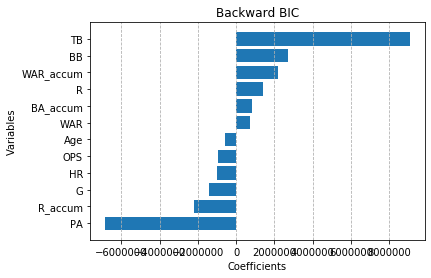

In [24]:
df_BIC_B = pd.DataFrame(results.params)
df_BIC_B.index.name = 'Variable'
df_BIC_B.reset_index(inplace=True)
df_BIC_B.columns = ["Variable", "Coefficient"]
df_BIC_B = df_BIC_B.sort_values(by = "Coefficient")
df_BIC_B = df_BIC_B[df_BIC_B["Variable"] != "Intercept"]

fig, ax = plt.subplots()
y_pos = np.arange(df_BIC_B.shape[0])
ax.barh(y_pos, df_BIC_B["Coefficient"], align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(df_BIC_B["Variable"])
ax.set_title("Backward BIC")
ax.set_xlabel("Coefficients")
ax.set_ylabel("Variables")
ax.xaxis.grid(linestyle='--')

Mean Square Error: 8,870,048,766,767.848


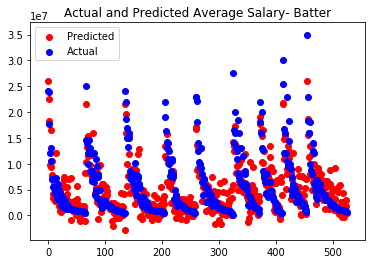

In [25]:
ypred = results.predict(X)
xlabl = np.arange(len(X))

print("Mean Square Error: {:,}".format(mean_squared_error(y, ypred)))
plt.scatter(xlabl, ypred, color = "red", label = "Predicted", marker = "o")
plt.scatter(xlabl, y, color = "blue", label = "Actual", marker = "o")
plt.title("Actual and Predicted Average Salary- Batter")
plt.legend()

# Comparing all six stepwise models

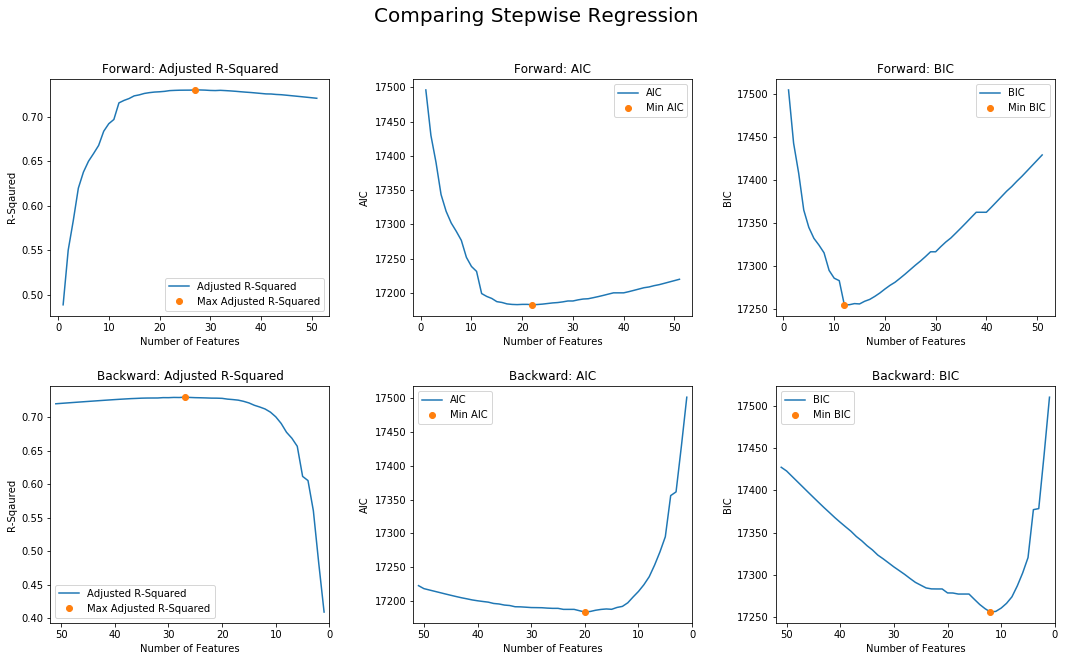

In [26]:
fig, ax = plt.subplots(nrows = 2,ncols = 3,figsize=(18,10))
fig.suptitle(t = "Comparing Stepwise Regression", fontsize = 20)
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

plt.subplot(2,3,1)
plt.plot(np.arange(1, ncol+1), adjr_squared_train, label = "Adjusted R-Squared")
plt.plot(adjr_squared_train.index(max(adjr_squared_train))+ 1, max(adjr_squared_train), "o", label = "Max Adjusted R-Squared")
plt.title("Forward: Adjusted R-Squared")
plt.xlabel("Number of Features")
plt.ylabel("R-Sqaured")
plt.legend()

plt.subplot(2,3,2)
plt.plot(np.arange(1, ncol+1), AIC_train, label = "AIC")
plt.plot(AIC_train.index(min(AIC_train))+ 1, min(AIC_train), "o", label = "Min AIC")
plt.title("Forward: AIC")
plt.xlabel("Number of Features")
plt.ylabel("AIC")
plt.legend()

plt.subplot(2,3,3)
plt.plot(np.arange(1, ncol+1), BIC_train, label = "BIC")
plt.plot(BIC_train.index(min(BIC_train))+ 1, min(BIC_train), "o", label = "Min BIC")
plt.title("Forward: BIC")
plt.xlabel("Number of Features")
plt.ylabel("BIC")
plt.legend()

plt.subplot(2,3,4)
plt.xlim(52, 0)
plt.plot(np.arange(ncol, 0, -1), adjr_squared, label = "Adjusted R-Squared")
plt.plot(51 - adjr_squared.index(max(adjr_squared)), max(adjr_squared), "o", label = "Max Adjusted R-Squared")
plt.title("Backward: Adjusted R-Squared")
plt.xlabel("Number of Features")
plt.ylabel("R-Sqaured")
plt.legend()

plt.subplot(2,3,5)
plt.xlim(52, 0)
plt.plot(np.arange(ncol, 0, -1), AIC, label = "AIC")
plt.plot(MinAIC_n_features, min(AIC), "o", label = "Min AIC")
plt.title("Backward: AIC")
plt.xlabel("Number of Features")
plt.ylabel("AIC")
plt.legend()

plt.subplot(2,3,6)
plt.xlim(52, 0)
plt.plot(np.arange(ncol, 0, -1), BIC, label = "BIC")
plt.plot(MinBIC_n_features, min(BIC), "o", label = "Min BIC")
plt.title("Backward: BIC")
plt.xlabel("Number of Features")
plt.ylabel("BIC")
plt.legend()

As we can see from the plot, the six different stepwise regression each comes up with different models. Comparing to the best subset method, stepwise regression are way more computationally efficient. However, each method comes up with different variables and coefficients, so it is important to look at the coefficients and interpret the results and see if they makes sense. 

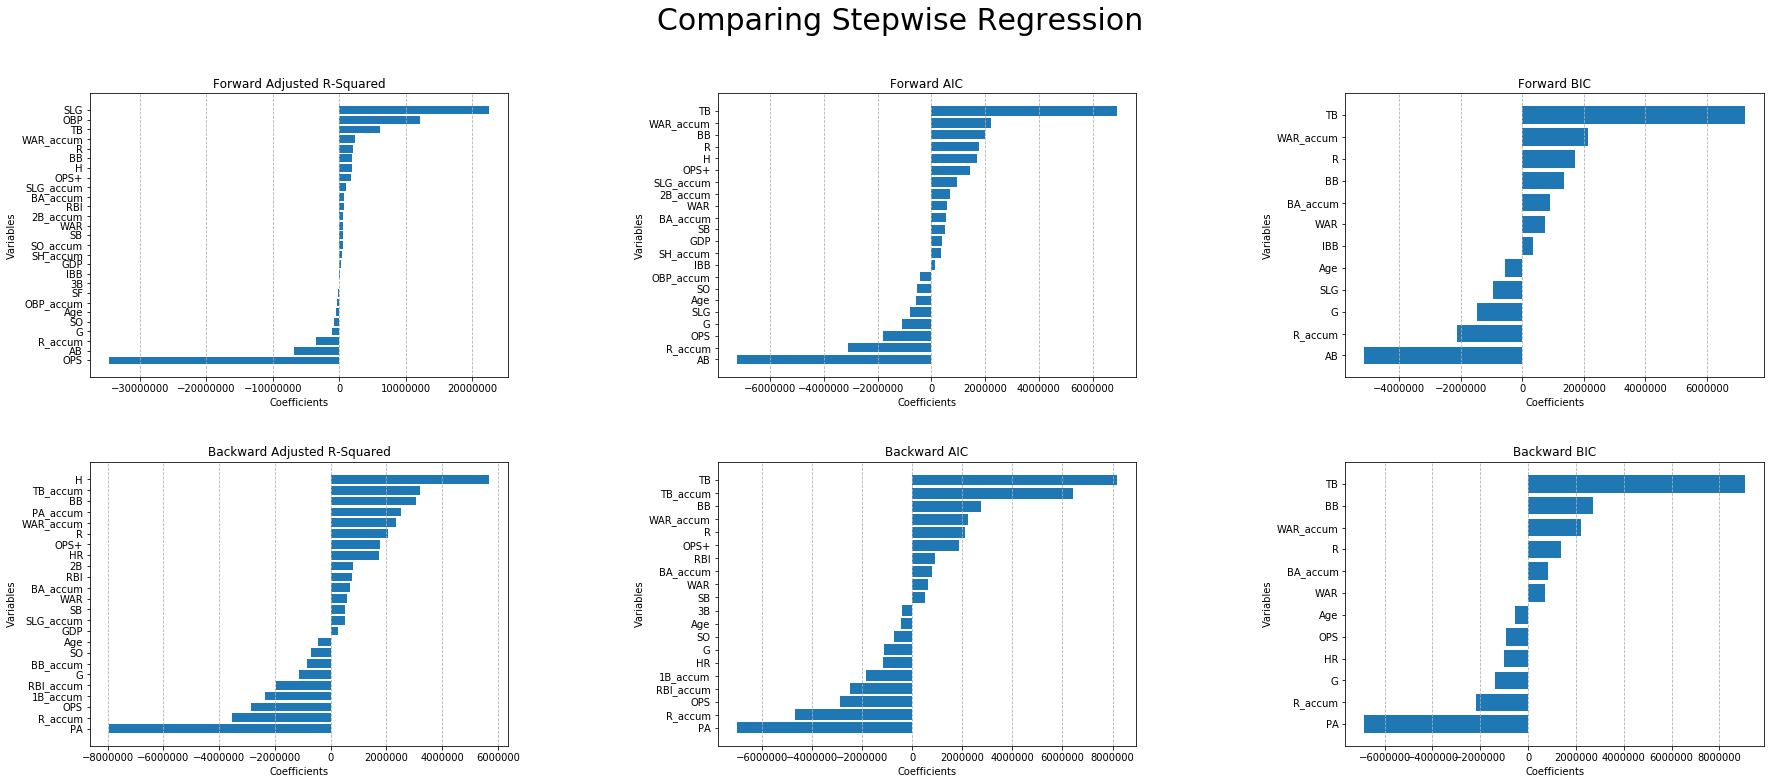

In [27]:
fig, ax = plt.subplots(nrows = 2,ncols = 3,figsize=(30,12))
fig.suptitle(t = "Comparing Stepwise Regression", fontsize = 30)
plt.subplots_adjust(wspace = 0.5, hspace = 0.3)

plt.subplot(2,3,1)
y_pos = np.arange(df_adjR_F.shape[0])
plt.barh(y_pos, df_adjR_F["Coefficient"], align='center')
plt.yticks(ticks = y_pos, labels = df_adjR_F["Variable"])
plt.ticklabel_format(axis = "x", style = "plain")
plt.title("Forward Adjusted R-Squared")
plt.xlabel("Coefficients")
plt.ylabel("Variables")
plt.grid(axis = "x", linestyle='--')

plt.subplot(2,3,2)
y_pos = np.arange(df_AIC_F.shape[0])
plt.barh(y_pos, df_AIC_F["Coefficient"], align='center')
plt.yticks(ticks = y_pos, labels = df_AIC_F["Variable"])
#plt.xticks(ticks = np.arange(-6000000, 6000001, 2000000), labels = np.arange(-6000000, 6000001, 2000000))
#plt.ticklabel_format(axis = "x", style = "sci")
plt.title("Forward AIC")
plt.xlabel("Coefficients")
plt.ylabel("Variables")
plt.grid(axis = "x", linestyle='--')

plt.subplot(2,3,3)
y_pos = np.arange(df_BIC_F.shape[0])
plt.barh(y_pos, df_BIC_F["Coefficient"], align='center')
plt.yticks(ticks = y_pos, labels = df_BIC_F["Variable"])
plt.title("Forward BIC")
plt.xlabel("Coefficients")
plt.ylabel("Variables")
plt.grid(axis = "x", linestyle='--')

plt.subplot(2,3,4)
y_pos = np.arange(df_adjR_B.shape[0])
plt.barh(y_pos, df_adjR_B["Coefficient"], align='center')
plt.yticks(ticks = y_pos, labels = df_adjR_B["Variable"])
plt.title("Backward Adjusted R-Squared")
plt.xlabel("Coefficients")
plt.ylabel("Variables")
plt.grid(axis = "x", linestyle='--')

plt.subplot(2,3,5)
y_pos = np.arange(df_AIC_B.shape[0])
plt.barh(y_pos, df_AIC_B["Coefficient"], align='center')
plt.yticks(ticks = y_pos, labels = df_AIC_B["Variable"])
plt.title("Backward AIC")
plt.xlabel("Coefficients")
plt.ylabel("Variables")
plt.grid(axis = "x", linestyle='--')

plt.subplot(2,3,6)
y_pos = np.arange(df_BIC_B.shape[0])
plt.barh(y_pos, df_BIC_B["Coefficient"], align='center')
plt.yticks(ticks = y_pos, labels = df_BIC_B["Variable"])
plt.title("Backward BIC")
plt.xlabel("Coefficients")
plt.ylabel("Variables")
plt.grid(axis = "x", linestyle='--')

In [28]:
# Print out all the selected features in the six models
print(selected_features_fwd_adjR2)
print(selected_features_fwd_AIC)
print(selected_features_fwd_BIC)
print(selected_features_bwd_adjR2)
print(selected_features_bwd_AIC)
print(selected_features_bwd_BIC)

['R', 'WAR', 'G', 'IBB', 'TB', 'AB', 'BB', 'BA_accum', 'Age', 'SLG', 'WAR_accum', 'R_accum', 'SO', 'SB', 'SLG_accum', 'SH_accum', 'GDP', 'H', '2B_accum', 'OBP_accum', 'OPS+', 'OPS', '3B', 'SO_accum', 'OBP', 'SF', 'RBI']
['R', 'WAR', 'G', 'IBB', 'TB', 'AB', 'BB', 'BA_accum', 'Age', 'SLG', 'WAR_accum', 'R_accum', 'SO', 'SB', 'SLG_accum', 'SH_accum', 'GDP', 'H', '2B_accum', 'OBP_accum', 'OPS+', 'OPS']
['R', 'WAR', 'G', 'IBB', 'TB', 'AB', 'BB', 'BA_accum', 'Age', 'SLG', 'WAR_accum', 'R_accum']
['1B_accum' '2B' 'Age' 'BA_accum' 'BB' 'BB_accum' 'G' 'GDP' 'H' 'HR' 'OPS'
 'OPS+' 'PA' 'PA_accum' 'R' 'RBI' 'RBI_accum' 'R_accum' 'SB' 'SLG_accum'
 'SO' 'TB_accum' 'WAR' 'WAR_accum']
['1B_accum' '3B' 'Age' 'BA_accum' 'BB' 'G' 'HR' 'OPS' 'OPS+' 'PA' 'R'
 'RBI' 'RBI_accum' 'R_accum' 'SB' 'SO' 'TB' 'TB_accum' 'WAR' 'WAR_accum']
['Age' 'BA_accum' 'BB' 'G' 'HR' 'OPS' 'PA' 'R' 'R_accum' 'TB' 'WAR'
 'WAR_accum']


Some findings after comparing the selected features and respective coefficients from differen stepwise regression. 
1. The variables each method selected are different: Even though the selected features are similar under forward and backward regression using the same criterion, the features are not exactly the same. Take the two BIC models for example, the backward and forward method both selected 12 features, but only nine of them are the same. 
2. Some signs of the coefficients do not make sense to me: It would be hard to believe that HR and OPS would have a negative impact on free agent signings. I am sure we could do better usign Lasso instead of stepwise. 

# Lasso

Lasso regression adds a l1 penalty to the linear regression equation. This penalty will force some of the coefficients to zero and therefore help with feature selections.

In [29]:
X = Batter[all_features_b]
y = Batter["Average_Salary"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 1)

X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

alpha_list = np.logspace(-10, 10)
MSE_list = []
coef_list = []
model_list = []
for alpha in alpha_list:
    lasso = Lasso(alpha = alpha, max_iter=100000, tol = 0.5)
    lasso.fit(X_train,y_train)
    ypred = lasso.predict(X_test)
    MSE = mean_squared_error(y_true = y_test, y_pred = ypred)
    MSE_list.append(MSE)
    coef_list.append(lasso.coef_)
    model_list.append(lasso)
# Min MSE index: MSE_list.index(min(MSE_list))
# The list of variables used in Lasso
best_model = model_list[MSE_list.index(min(MSE_list))]
bset_alpha = alpha_list[MSE_list.index(min(MSE_list))]
variables_lasso = X.columns[coef_list[MSE_list.index(min(MSE_list))] != 0]  # The variables that Lasso keeps (coef != 0)
print(variables_lasso)
df_dict = {"Variable": variables_lasso, "Coefficient": np.round(best_model.coef_[coef_list[MSE_list.index(min(MSE_list))] != 0], 2)}
best_lasso_df = pd.DataFrame(df_dict)

Index(['Age', 'G', 'PA', 'R', 'HR', 'SB', 'BB', 'SO', 'OBP', 'OPS', 'OPS+',
       'SH', 'IBB', 'WAR', 'G_accum', 'HR_accum', 'BA_accum', 'OBP_accum',
       'SLG_accum', 'HBP_accum', '1B_accum', 'WAR_accum'],
      dtype='object')


If we only do lasso once, the results are highly dependent on the train test split. Use 10-fold cross validation to better estimate the true test error.

Text(0, 0.5, 'Number of variables selected by lasso')

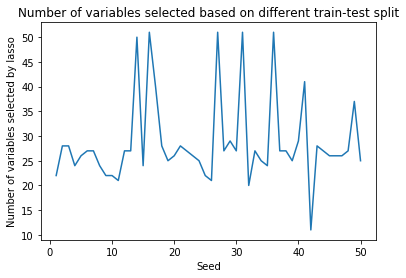

In [30]:
variables_used = []
for i in range(1, 51, 1):
    X = Batter[all_features_b]
    y = Batter["Average_Salary"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = i)

    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)

    alpha_list = np.logspace(-10, 10)
    MSE_list = []
    coef_list = []
    model_list = []
    
    for alpha in alpha_list:
        lasso = Lasso(alpha = alpha, max_iter=100000, tol = 0.5)
        lasso.fit(X_train,y_train)
        ypred = lasso.predict(X_test)
        MSE = mean_squared_error(y_true = y_test, y_pred = ypred)
        MSE_list.append(MSE)
        coef_list.append(lasso.coef_)
        model_list.append(lasso)
    
    variables_lasso = X.columns[coef_list[MSE_list.index(min(MSE_list))] != 0]  # The variables that Lasso keeps (coef != 0)
    variables_used.append(len(variables_lasso))
# print("Number of variables used in seed 1-50:", variables_used)
plt.plot(np.linspace(1,50,50), variables_used)
plt.title("Number of variables selected based on different train-test split")
plt.xlabel("Seed")
plt.ylabel("Number of variables selected by lasso")

From the plot above we can see that the numbers of coefficients selected is fluctuating as the train-test split varies. We can use 10-fold cross validation to find the best lasso model. 

# 10-fold Cross Validation

We use 10-fold cross validation to help find the best alpha with the lowest 10-fold MSE. Then we use the alpha that we find to run the lasso using all data.  

In [67]:
# 10 fold with normalization
k = 10
alpha_list = np.logspace(-10, 10)            # A list of different alphas to loop through 
X = Batter[all_features_b]
y = Batter["Average_Salary"]
kf = KFold(n_splits=k, shuffle = True, random_state = 1)
kf.get_n_splits(X)
MSE_fold = []
coef_fold = []
model_fold = []
for train_index, test_index in kf.split(X):
        X_train, X_test = X.loc[train_index, :], X.loc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        X_train = scaler.fit_transform(X_train)
        X_test  = scaler.transform(X_test)
        MSE_list = []
        coef_list = []
        model_list = []
        for alpha in alpha_list:
            lasso = Lasso(alpha = alpha, max_iter=100000, tol = 0.5)
            lasso.fit(X_train,y_train)
            ypred = lasso.predict(X_test)
            MSE = mean_squared_error(y_true = y_test, y_pred = ypred)
            MSE_list.append(MSE)
            coef_list.append(lasso.coef_)
            model_list.append(lasso)
        MSE_fold.append(MSE_list)
        coef_fold.append(coef_list)
        model_fold.append(model_list)

# The MSE mean at each alpha        
MSE_mean = []
for j in range(len(alpha_list)):
    MSE_sum = 0
    for i in range(k):
        MSE_sum = MSE_sum + MSE_fold[i][j]
    MSE_mean.append(MSE_sum/k)  
    
X = Batter[all_features_b]
X = scaler.fit_transform(X)
y = Batter["Average_Salary"]
lasso = Lasso(alpha = alpha_list[MSE_mean.index(min(MSE_mean))], max_iter=100000, tol = 0.5)
lasso.fit(X,y)

variables_lasso = Batter[all_features_b].columns[lasso.coef_ != 0]  # The variables that Lasso keeps (coef != 0)
df_dict = {"Variable": variables_lasso, "Coefficient": np.round(lasso.coef_[lasso.coef_ != 0], 2)}
best_lasso_df = pd.DataFrame(df_dict)
best_lasso_df.sort_values(by = "Coefficient", ascending = False)

,Variable,Coefficient
3,R,1529299.15
2,PA,1468881.94
16,WAR,1093966.93
5,HR,844947.19
27,WAR_accum,754272.54
15,IBB,511209.01
20,OBP_accum,373564.30
21,SLG_accum,331704.70
9,OBP,238313.31
19,BA_accum,196410.37


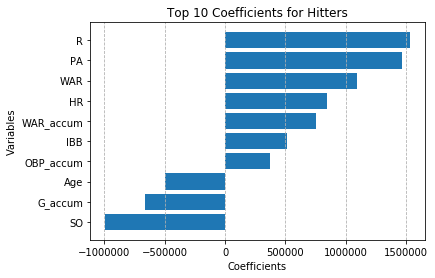

In [32]:
# Find the top 10 variables that affects average salary
temp = best_lasso_df.sort_values(by = "Coefficient")
imp_coef = temp[[i in sorted(temp["Coefficient"], key = abs, reverse = True)[0:10] for i in temp["Coefficient"]]]

fig, ax = plt.subplots()
y_pos = np.arange(imp_coef.shape[0])
ax.barh(y_pos, imp_coef["Coefficient"], align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(imp_coef["Variable"])
ax.set_title("Top 10 Coefficients for Hitters")
ax.set_xlabel("Coefficients")
ax.set_ylabel("Variables")
ax.xaxis.grid(linestyle='--')

Comparing to the results from stepwise regression, the signs of the coefficients make more sense. However, I am surprised by some of the results. I did not expect "R" to be the most impactful coefficient followed by "PA". "WAR" and "HR" are not surprising at all because they are a really direct reflection of how well a hitter is. IBB seems like a fair indicator as well because it shows how opposing pitchers "respects" the hitter, especially at close situations. The negative coefficients are "Age", "G_accum" and "SO". "Age" and "G_Accum" are somewhat correlated, the more games a hitter plays, the older a hitter generally is. Getting struck out is the least productive out on the baseball field, and it definitely shows it right here. 

# Predicting Average Salary for Mookie Betts and Mike Trout

Mike Trout and Mookie Betts are arguably the best hitters in baseball right now and they both signed massive extentsions from their respective Los Angeles teams. Mike Trout signed a \\$426,500,000 contract over 12 years with the Angels while Mookie Betts signed a \\$365,000,000 contract over 12 years with the dodgers. Their average salary would be \\$35,541,666 and \\$30,416,666 respectively.  <br>
Let's see how our model says about their average salary.

In [52]:
MB = pd.DataFrame(np.array([[27, 150, 706, 597, 135, 176, 40, 5, 29, 80, 16, 3, 97, 101, .295, .391, .524, .915, 135, 313, 11, 3, 0, 9, 6, 6.9, 794, 3629, 3203, 613, 965, 229, 26, 139, 470, 126, 25, 371, 464, .301, .374, .519, .893, 134, 1663, 41, 19, 32, 25, 571, 41.7]]), columns = all_features_b)
MB

,Age,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,BA,OBP,SLG,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB,WAR,G_accum,PA_accum,AB_accum,R_accum,H_accum,2B_accum,3B_accum,HR_accum,RBI_accum,SB_accum,CS_accum,BB_accum,IBB_accum,SO_accum,BA_accum,OBP_accum,SLG_accum,OPS_accum,TB_accum,GDP_accum,HBP_accum,SH_accum,SF_accum,1B_accum,WAR_accum
0,27.0,150.0,706.0,597.0,135.0,176.0,40.0,5.0,29.0,80.0,16.0,3.0,97.0,101.0,0.295,0.391,0.524,0.915,135.0,313.0,11.0,3.0,0.0,9.0,6.0,6.9,794.0,3629.0,3203.0,613.0,965.0,229.0,26.0,139.0,470.0,126.0,25.0,371.0,464.0,0.301,0.374,0.519,0.893,134.0,1663.0,41.0,19.0,32.0,25.0,571.0,41.7


In [69]:
lasso.predict(scaler.transform(MB))

array([29765798.41544905])

In [70]:
MT = pd.DataFrame(np.array([[27, 134, 600, 470, 110, 137, 27, 2, 45, 104, 11, 2, 110, 120, .291, .438, .645, 1.083, 183, 303, 5, 16, 0, 4, 14, 8.2, 1199, 5273, 4340, 903, 1324, 251, 46, 285, 752, 200, 36, 803, 1118, .305, .419, .581, 1, 176, 2522, 57, 81, 0, 48, 742, 72.8]]), columns = all_features_b)
MT

,Age,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,BA,OBP,SLG,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB,WAR,G_accum,PA_accum,AB_accum,R_accum,H_accum,2B_accum,3B_accum,HR_accum,RBI_accum,SB_accum,CS_accum,BB_accum,IBB_accum,SO_accum,BA_accum,OBP_accum,SLG_accum,OPS_accum,TB_accum,GDP_accum,HBP_accum,SH_accum,SF_accum,1B_accum,WAR_accum
0,27.0,134.0,600.0,470.0,110.0,137.0,27.0,2.0,45.0,104.0,11.0,2.0,110.0,120.0,0.291,0.438,0.645,1.083,183.0,303.0,5.0,16.0,0.0,4.0,14.0,8.2,1199.0,5273.0,4340.0,903.0,1324.0,251.0,46.0,285.0,752.0,200.0,36.0,803.0,1118.0,0.305,0.419,0.581,1.0,176.0,2522.0,57.0,81.0,0.0,48.0,742.0,72.8


In [71]:
lasso.predict(scaler.transform(MT))

array([34239828.33022706])

Turns out that our model performed pretty well on top tier players!! I am so surprised that the predicted average salary are so accurate! 

Mean Square Error: 10,639,900,992,223.463


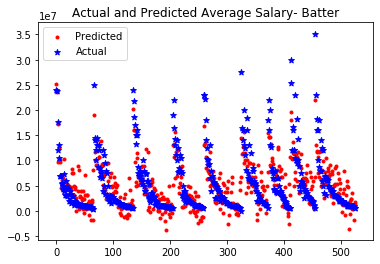

In [78]:
ypred = lasso.predict(X)
xlabl = np.arange(len(X))

print("Mean Square Error: {:,}".format(mean_squared_error(y, ypred)))
plt.scatter(xlabl, ypred, color = "red", label = "Predicted", marker = ".")
plt.scatter(xlabl, y, color = "blue", label = "Actual", marker = "*")
plt.title("Actual and Predicted Average Salary- Batter")
plt.legend()

The scatter plot above shows the predicted average salary and the actual average salary for all the batters we used in the lasso model. Our model seems to perform better in the mid to high average salary section. Some predictions for the lower tier players are even negative. But overall, the predictions match the actual figures pretty well, no predictions are wildly off the target. 

# Lasso Regression for Pitchers

Because the nature of starting pitchers and relief pitchers are so different, I would run seperate models on them respectively. The way I define a starting pitcher is that he starts over half of his games. 

In [34]:
all_features_p = ['W', 'L', 'ERA', 'G', 'GS', 'GF', 'CG', 'SHO', 'SV',
       'IP', 'H', 'R', 'ER', 'HR', 'BB', 'IBB', 'SO', 'HBP', 'WP', 'BF',
       'ERA+', 'FIP', 'WHIP', 'H9', 'HR9', 'BB9', 'SO9', 'SO/W', 'WAR',
       'W_accum', 'L_accum', 'ERA_accum', 'G_accum', 'GS_accum',
       'GF_accum', 'CG_accum', 'SHO_accum', 'SV_accum', 'IP_accum', 'H_accum',
       'R_accum', 'ER_accum', 'HR_accum', 'BB_accum', 'IBB_accum', 'SO_accum',
       'HBP_accum', 'WP_accum', 'BF_accum', 'WHIP_accum',
       'H9_accum', 'HR9_accum', 'BB9_accum', 'SO9_accum', 'SO/W_accum',
       'WAR_accum']

In [35]:
SP_df = Pitcher[Pitcher["Position"] == "SP"].dropna()
RP_df = Pitcher[Pitcher["Position"] == "RP"].dropna()
SP_df = SP_df.reset_index()
RP_df = RP_df.reset_index()

# Starting Pitcher 10-fold

For Starting pitchers, the most important stats are SO, IP, ERA+

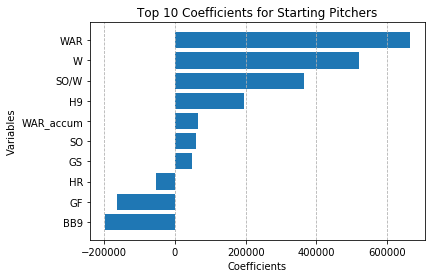

In [36]:
k = 10
alpha_list = np.logspace(-10, 10)            # A list of different alphas to loop through 
X = SP_df[all_features_p]
y = SP_df["Average_Salary"]
kf = KFold(n_splits=k, shuffle = True, random_state = 1)
kf.get_n_splits(X)
MSE_fold = []
coef_fold = []
model_fold = []
for train_index, test_index in kf.split(X):
        X_train, X_test = X.loc[train_index, :], X.loc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        X_train = scaler.fit_transform(X_train)
        X_test  = scaler.transform(X_test)
        MSE_list = []
        coef_list = []
        model_list = []
        for alpha in alpha_list:
            lasso = Lasso(alpha = alpha, max_iter=100000, tol = 0.5)
            lasso.fit(X_train,y_train)
            ypred = lasso.predict(X_test)
            MSE = mean_squared_error(y_true = y_test, y_pred = ypred)
            MSE_list.append(MSE)
            coef_list.append(lasso.coef_)
            model_list.append(lasso)
        MSE_fold.append(MSE_list)
        coef_fold.append(coef_list)
        model_fold.append(model_list)

# The MSE mean at each alpha        
MSE_mean = []
for j in range(len(alpha_list)):
    MSE_sum = 0
    for i in range(k):
        MSE_sum = MSE_sum + MSE_fold[i][j]
    MSE_mean.append(MSE_sum/k)    
    
X = SP_df[all_features_p]
y = SP_df["Average_Salary"]
lasso = Lasso(alpha = alpha_list[MSE_mean.index(min(MSE_mean))], max_iter=100000, tol = 0.5)
lasso.fit(X,y)

variables_lasso = X.columns[lasso.coef_ != 0]  # The variables that Lasso keeps (coef != 0)
df_dict = {"Variable": variables_lasso, "Coefficient": np.round(lasso.coef_[lasso.coef_ != 0], 2)}
best_lasso_df = pd.DataFrame(df_dict)

temp = best_lasso_df.sort_values(by = "Coefficient")
imp_coef = temp[[i in sorted(temp["Coefficient"], key = abs, reverse = True)[0:10] for i in temp["Coefficient"]]]

fig, ax = plt.subplots()
y_pos = np.arange(imp_coef.shape[0])
ax.barh(y_pos, imp_coef["Coefficient"], align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(imp_coef["Variable"])
ax.set_title("Top 10 Coefficients for Starting Pitchers")
ax.set_xlabel("Coefficients")
ax.set_ylabel("Variables")
ax.xaxis.grid(linestyle='--')

For starting pitchers, the most important factor is "WAR" followed by "W" and "SO/W". I am surprised to see that H9 has a positive effect on average salary, because generally speaking pitchers would like to give up as few hits as possible. I am also surprised that "IP" did not make the top ten because people always consider how many innings a starting pitcher can throw as a good indicator. 

## Relief Pitchers

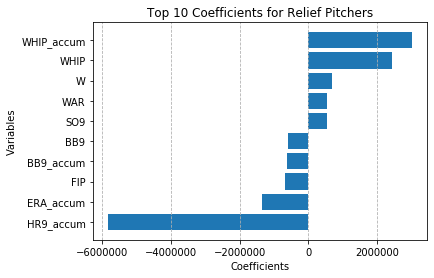

In [37]:
k = 10
alpha_list = np.logspace(-10, 10)            # A list of different alphas to loop through 
X = RP_df[all_features_p]
y = RP_df["Average_Salary"]
kf = KFold(n_splits=k, shuffle = True, random_state = 1)
kf.get_n_splits(X)
MSE_fold = []
coef_fold = []
model_fold = []
for train_index, test_index in kf.split(X):
        X_train, X_test = X.loc[train_index, :], X.loc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        X_train = scaler.fit_transform(X_train)
        X_test  = scaler.transform(X_test)
        MSE_list = []
        coef_list = []
        model_list = []
        for alpha in alpha_list:
            lasso = Lasso(alpha = alpha, max_iter=100000, tol = 0.5)
            lasso.fit(X_train,y_train)
            ypred = lasso.predict(X_test)
            MSE = mean_squared_error(y_true = y_test, y_pred = ypred)
            MSE_list.append(MSE)
            coef_list.append(lasso.coef_)
            model_list.append(lasso)
        MSE_fold.append(MSE_list)
        coef_fold.append(coef_list)
        model_fold.append(model_list)

# The MSE mean at each alpha        
MSE_mean = []
for j in range(len(alpha_list)):
    MSE_sum = 0
    for i in range(k):
        MSE_sum = MSE_sum + MSE_fold[i][j]
    MSE_mean.append(MSE_sum/k)    
    
X = SP_df[all_features_p]
y = SP_df["Average_Salary"]
lasso = Lasso(alpha = alpha_list[MSE_mean.index(min(MSE_mean))], max_iter=100000, tol = 0.5)
lasso.fit(X,y)

variables_lasso = X.columns[lasso.coef_ != 0]  # The variables that Lasso keeps (coef != 0)
df_dict = {"Variable": variables_lasso, "Coefficient": np.round(lasso.coef_[lasso.coef_ != 0], 2)}
best_lasso_df = pd.DataFrame(df_dict)

temp = best_lasso_df.sort_values(by = "Coefficient")
imp_coef = temp[[i in sorted(temp["Coefficient"], key = abs, reverse = True)[0:10] for i in temp["Coefficient"]]]

fig, ax = plt.subplots()
y_pos = np.arange(imp_coef.shape[0])
ax.barh(y_pos, imp_coef["Coefficient"], align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(imp_coef["Variable"])
ax.set_title("Top 10 Coefficients for Relief Pitchers")
ax.set_xlabel("Coefficients")
ax.set_ylabel("Variables")
ax.xaxis.grid(linestyle='--')

We can see that the coefficients for relief pitchers are very different from starting pitchers. For relief pitchers, HR9 and ERA are more important. However, the positive coefficients of WHIP is surprising because a high WHIP means that a pitcher is letting more batters reach base. A good pitcher should have a low WHIP. 

# Conclusion

There are many factors that goes into evaluating a free agent, such as the leadership and personality of a player, the preference of the teams and the player, the competitiveness of that position in that year and many more. These are the factors that are not easily incorporated in a quantitative model. Even the stats itself might not be enough, as more advanced statistics such as wRC, wRC+ are introduced to the game of baseball. Moreover, using career stats might not be a good choice because it might benefit veteran players that accumulated more stats than young players. Perhaps using the previous 5-year cumulative stats would result in a better prediction. There are still a few things that I could work more on. <br> 

I really enjoyed working on this project because it incorporates the two things that I love the most, data and baseball. I get to polish my skills in webscraping, data visualization in python and review my understanding in statistics and model building. I would also like to share a few things that I learned throughout this project. <br> 

1. Lasso is easier to implement than stepwise regression. Moreover, it generates better results that are both intepretable and accurate. 
2. Best subset selection on a 20+ variables are unrealistic. I have tried running 51 variables and I could not even reach 20% after 10 hours. 
3. Intepreting the results are just as important as building the models. Some coefficients or variables may not make sense, so domain knowledge is essential to data analytics. If I no nothing about baseball, I might be content with the results in stepwise regression.

# Appendix 

## Best Subset Selection - All Variables

In [37]:
# Full Model - 51 variables
# Don't RUN! Too long to run
# 2*51 models
"""df = Batter.iloc[:,np.append(2, np.arange(15,65))]
y = Batter["Average_Salary"]
import itertools 
model_each_n = []
MaxadjR2_each_n = []
adjR2_each_n = []
adjR2_best_features_each_n = []
AIC_best_features_each_n = []
BIC_best_features_each_n = []
for j in range(len(df.columns)):     # Loop through each n (the number of variables used: 1 ~ ncol)
    adjR2_each_combin = []
    AIC_each_combin = []
    BIC_each_combin = []
    adjR2_feature_each_combin = []
    for i in itertools.combinations(df.columns, j+1):   # Loop through all combinations of j (1~ncol)
        feature_combin.append(i)
        X = df.loc[:,i]
        X = X.assign(Intercept=1)
        ols = sm.OLS(y,X)
        results = ols.fit()
        adjR2 = results.rsquared_adj
        adjR2_each_combin.append(adjR2)  # A list of adjR2 in this inner loop 
        AIC = results.aic
        AIC_each_combin.append(AIC)
        BIC = results.bic
        BIC_each_combin.append(BIC) 
        model_each_n.append(results)
    MaxadjR2 = max(adjR2_each_combin)
    MaxadjR2_each_n.append(MaxadjR2)     # A list of highest adjR2 in each round 
    MaxadjR2_index = adjR2_each_combin.index(MaxadjR2)
    adjR2_best_features = adjR2_feature_each_combin[MaxadjR2_index]       # The features selected under each n 
    adjR2_best_features_each_n.append(adjR2_best_features)           # A list of selected features in each n
    adjR2_each_n.append(adjR2_each_combin)               # Record ALL adjR2 for every model built
    MinAIC = min(AIC_each_combin)
    MinAIC_index = AIC_each_combin.index(MinAIC)
    AIC_best_features = AIC_feature_each_combin[MinAIC_index]
    AIC_best_features_each_n.append(AIC_best_features)
    MinBIC = min(BIC_each_combin)
    MinBIC_index = BIC_each_combin.index(MinBIC)
    BIC_best_features = BIC_feature_each_combin[MinBIC_index]
    BIC_best_features_each_n.append(BIC_best_features)"""

'df = Batter.iloc[:,np.append(2, np.arange(15,65))]\ny = Batter["Average_Salary"]\nimport itertools \nmodel_each_n = []\nMaxadjR2_each_n = []\nadjR2_each_n = []\nadjR2_best_features_each_n = []\nAIC_best_features_each_n = []\nBIC_best_features_each_n = []\nfor j in range(len(df.columns)):     # Loop through each n (the number of variables used: 1 ~ ncol)\n    adjR2_each_combin = []\n    AIC_each_combin = []\n    BIC_each_combin = []\n    adjR2_feature_each_combin = []\n    for i in itertools.combinations(df.columns, j+1):   # Loop through all combinations of j (1~ncol)\n        feature_combin.append(i)\n        X = df.loc[:,i]\n        X = X.assign(Intercept=1)\n        ols = sm.OLS(y,X)\n        results = ols.fit()\n        adjR2 = results.rsquared_adj\n        adjR2_each_combin.append(adjR2)  # A list of adjR2 in this inner loop \n        AIC = results.aic\n        AIC_each_combin.append(AIC)\n        BIC = results.bic\n        BIC_each_combin.append(BIC) \n        model_each_n.appen

## Ridge

Like Lasso regression, Ridge regression adds a penalty to linear regression formula. However, Ridge regression uses l2 penalty instead of l1 and it will not force the coefficients to zero. 

In [38]:
X = Batter[all_features_b]
y = Batter["Average_Salary"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 1)

X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

alpha_list = np.logspace(-10, 10)
MSE_list = []
coef_list = []
for alpha in alpha_list:
    ridge = Ridge(alpha = alpha, max_iter=100000, tol = 0.5)
    ridge.fit(X_train,y_train)
    ypred = ridge.predict(X_test)
    MSE = mean_squared_error(y_true = y_test, y_pred = ypred)
    MSE_list.append(MSE)
    coef_list.append(ridge.coef_)
# Min MSE: MSE_list.index(min(MSE_list))
# The list of variables used in Lasso
variables_ridge = X.columns[coef_list[MSE_list.index(min(MSE_list))] != 0]
df_dict = {"Variable": variables_ridge, "Coefficient": np.round(ridge.coef_, 4)}
best_ridge_df = pd.DataFrame(df_dict)
best_ridge_df.sort_values(by = "Coefficient")

,Variable,Coefficient
47,SH_accum,-0.0348
0,Age,-0.0347
22,SH,-0.0320
46,HBP_accum,0.0177
32,3B_accum,0.0272
36,CS_accum,0.0282
35,SB_accum,0.0295
11,CS,0.0396
26,G_accum,0.0424
49,1B_accum,0.0462


## MSE at different Alpha 

Text(0, 0.5, 'MSE')

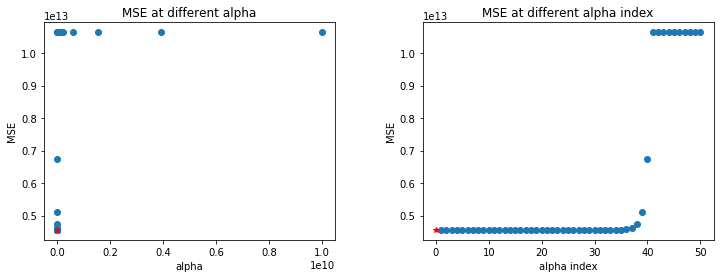

In [39]:
fig, ax = plt.subplots(nrows = 1,ncols = 2,figsize=(12,4))
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

plt.subplot(1,2,1)
plt.scatter(alpha_list, MSE_mean)
plt.plot(alpha_list[MSE_mean.index(min(MSE_mean))], min(MSE_mean), color = "red", marker = "*")
plt.title("MSE at different alpha")
plt.xlabel("alpha")
plt.ylabel("MSE")

plt.subplot(1,2,2)
plt.scatter(np.linspace(1,50,50), MSE_mean)
plt.plot(MSE_mean.index(min(MSE_mean)), min(MSE_mean), color = "red", marker = "*")
plt.title("MSE at different alpha index")
plt.xlabel("alpha index")
plt.ylabel("MSE")